Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.core.display import display, HTML
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pickle

Explore dataset

In [ ]:
movies_8000 = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/IMDb_8000.pickle'))
df1 = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/IMDb_top_movies.pickle'))
df2 = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/IMDb_top_2000s.pickle'))
movies_8100 = pd.concat([movies_8000,df1,df2])
movies_8100.head()

,movie title,imdb rating,imdb raters,mpaa,genres,director,writer,stars,country,language,release date,budget,opening weekend,gross usa,cumulative worldwide,production companies,runtime (min)
0,Mulan,5.4,57966.0,PG-13,"[Action, Adventure, Drama, Family]",Niki Caro,Rick Jaffa,"[Yifei Liu, Donnie Yen, Li Gong]",USA,English,2020-09-04,200000000.0,NaN,NaN,66800000.0,"[Walt Disney Pictures, Jason T. Reed Productio...",115.0
1,The Invisible Man,7.1,136012.0,R,"[Horror, Mystery, Sci-Fi, Thriller]",Leigh Whannell,Leigh Whannell,"[Elisabeth Moss, Oliver Jackson-Cohen, Harriet...",Canada,English,2020-02-28,7000000.0,28205665.0,64914050.0,130722137.0,"[Universal Pictures, Blumhouse Productions, Go...",124.0
2,On the Basis of Sex,7.1,23877.0,PG-13,"[Biography, Drama]",Mimi Leder,Daniel Stiepleman,"[Felicity Jones, Armie Hammer, Justin Theroux]",USA,English,2019-01-11,20000000.0,686355.0,24704837.0,38755900.0,"[Alibaba Pictures, Amblin Partners, DreamWorks]",120.0
3,The Gentlemen,7.9,188297.0,R,"[Action, Comedy, Crime]",Guy Ritchie,Guy Ritchie,"[Matthew McConaughey, Charlie Hunnam, Michelle...",UK,English,2020-01-24,22000000.0,10651884.0,36471795.0,115171795.0,"[STX Films, Miramax, Toff Guy Films]",113.0
4,Knives Out,7.9,394738.0,PG-13,"[Comedy, Crime, Drama, Mystery, Thriller]",Rian Johnson,Rian Johnson,"[Daniel Craig, Chris Evans, Ana de Armas]",USA,English,2019-11-27,40000000.0,26769548.0,165363234.0,309232797.0,"[Lionsgate, Media Rights Capital (MRC), T-Street]",130.0


Clean dataset

In [ ]:
movies_8100 = movies_8100.drop(['runtime (min)','opening weekend','writer','country','language','opening weekend','gross usa'],axis=1)


In [ ]:
movies_df = movies_8100.copy()
movies_df.drop_duplicates(subset=['movie title'],inplace=True)
# Copy the original dataframe to mess with the data more freely
movies_df.set_index('movie title',inplace=True)
movies_df_drop = movies_df.dropna(subset=['budget'])

In [ ]:
movie_drop2 = movies_df_drop[movies_df_drop['imdb rating'].notna()]
movie_drop2 = movies_df_drop[movies_df_drop['mpaa'].notna()]
# Drop movies without a rating

In [ ]:
movie_drop2 = movie_drop2[movie_drop2['imdb raters'] >= 10000]
# Remove movies with less than 1,000 raters for better validity in ratings
movie_drop2 = movie_drop2[movie_drop2['budget'] >= 10000]
# Remove movies with less than a $1,000 budget to focus model

Extract the feaatures we want from the original dataset


Feature: MPAA

In [ ]:
mpaa_df = pd.get_dummies(movie_drop2['mpaa'])
# Get dummy variables for MPAA ratings
df_added_mpaa_dummies = pd.concat([movie_drop2,mpaa_df], axis=1)
# Add them to the rest of the data
df_added_mpaa_dummies = df_added_mpaa_dummies.drop('mpaa',axis=1)
df_added_mpaa_dummies = df_added_mpaa_dummies.drop(['Not Rated','Unrated'],axis=1)

Feature: Genre

In [ ]:
df_genres_added = pd.Series(df_added_mpaa_dummies['genres'])
df_genres_added = pd.get_dummies(df_genres_added.apply(pd.Series).stack()).sum()
# Turns genres into dummy variables
df_genres_mpaa = pd.concat([df_added_mpaa_dummies, df_genres_added], axis=1)
df_genres_mpaa = df_genres_mpaa.drop('genres',axis=1)
df_genres_mpaa = df_genres_mpaa.drop('imdb raters',axis=1)

Feature: Director

In [ ]:
empty_dir = movie_drop2[movie_drop2['director']==''].index.values.tolist()
dir_fill = [
    'Peter Ramsey, Bob Persichetti, Rodney Rothman',
    'Ron Clements, John Musker',
    'Byron Howard, Rich Moore',
    'Pierre Coffin, Chris Renaud',
    'Charlie Bean, Bob Logan, Paul Fisher',
    'Frank Miller, Quentin Tarantino, Robert Rodriguez',
    'Dan Scanlon, Saschka Unseld'
    ]
for num, movie in enumerate(empty_dir):
    movie_drop2['director'][movie] = dir_fill[num]
# Run through the empty directors and fill with added info

In [ ]:
def directors_list(directors):
    """
    Separates a string of directors into a list of the separate directors.
    Args:
        directors: A string of directors separated by commas
    Returns:
        A list of directors.
    """
    if "," in directors:
        return [name.strip() for name in directors.split(",")]
    else:
        return [directors]


def remove_paren(directors):
    """
    Takes off aliases that are in parentheses next to a director's name
    Args:
        directors: A list of directors
    Returns:
        The same list of directors, but without aliases in parenthesis.
    """
    dir_list = []
    for director in directors:
        if "(" in director:
            dir_clean = director.split("(")[0].strip()
            dir_list.append(dir_clean)
        else:
            dir_list.append(director)
    return dir_list

In [ ]:
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: directors_list(x))
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: remove_paren(x))


In [ ]:
df_dir_exploded = movie_drop2.explode('director')
dir_10 = df_dir_exploded['director'].value_counts()[:10].index.tolist()
def top_directors(directors):
    dir_list = []
    for director in directors:
        if director in dir_10:
            dir_list.append(director)
    return dir_list
# Create a function to select top directors and create new columns
# This will let us create dummy variables just for top directors

movie_drop2['top'] = movie_drop2['director'].apply(lambda x: top_directors(x))
# Apply that function to create a new column
dir_df = pd.get_dummies(movie_drop2['top'].apply(pd.Series).stack()).sum()
# Get dummies for the top directors
df_dir_model = pd.concat([df_genres_mpaa, dir_df], axis=1)
# Merge dummies with model DataFrame
df_dir_model.replace(np.nan,0,inplace=True)

Feature: Stars

In [ ]:
stars_exploded = movie_drop2.explode('stars')
# Let's do something similar to director
stars_20 = stars_exploded['stars'].value_counts()[:20].index.tolist()
# Let's take the top 20 stars instead of just 10
def top_stars(stars):
    star_list = []
    for star in stars:
        if star in stars_20:
            star_list.append(star)
    return star_list
# Create a function to select top stars and create new columns
# This will let us create dummy variables just for top stars
movie_drop2['top stars'] = movie_drop2['stars'].apply(lambda x: top_stars(x))
stars_df = pd.get_dummies(movie_drop2['top stars'].apply(pd.Series).stack()).sum()
star_model = pd.concat([df_dir_model, stars_df[stars_20]], axis=1)
star_model.replace(np.nan,0,inplace=True)

Feature: Production Company

In [ ]:
prod_exploded = movie_drop2.explode('production companies')
# You know the drill
prod_15 = prod_exploded['production companies'].value_counts()[:15].index.tolist()
movie_drop2.loc[movie_drop2['production companies'].isnull(),'production companies'] = movie_drop2.loc[movie_drop2['production companies'].isnull(),'production companies'].apply(lambda x: [])
def top_prod(comp):
    comp_list = []
    for co in comp:
        if co in prod_15:
            comp_list.append(co)
    return comp_list
movie_drop2['top prod co.'] = movie_drop2['production companies'].apply(lambda x: top_prod(x))
prod_df = pd.get_dummies(movie_drop2['top prod co.'].apply(pd.Series).stack()).sum()
prod_model = pd.concat([star_model, prod_df[prod_15]], axis=1)
prod_model.replace(np.nan,0,inplace=True)

Feature: Years since release

In [ ]:
date = pd.to_datetime(datetime.now().date())
movie_drop2['years since release'] = movie_drop2['release date'].apply(lambda x: (((date-pd.to_datetime(x))).days/ 365.25))
prod_model['years since release'] = movie_drop2['years since release']
prod_model = prod_model.drop(['director','stars','release date','production companies'],axis=1)


Create the classes for movie rating: 0-4 rating class 1, 4-7 rating class 2, 7-10 rating class 3.

In [ ]:
criteria = [prod_model['imdb rating'].between(0, 4), prod_model['imdb rating'].between(4, 7), prod_model['imdb rating'].between(7, 10)]
values = [1, 2,3]
prod_model['target'] = np.select(criteria, values, 0)
prod_model.tail()
prod_model = prod_model.drop('imdb rating',axis=1)

Create X_train, X_test, y_train, y_test

In [ ]:
X, y = prod_model.iloc[:,1:73], prod_model['target']
cols = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)

Define all the classifiers

In [ ]:
rf = RandomForestClassifier(n_estimators=1000)
KNN = KNeighborsClassifier()
Extra = ExtraTreesClassifier()
GD = GradientBoostingClassifier()

Using ensembler learning via voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("KNN", KNN), ("rf", rf), ("Extra", Extra),("GD",GD)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting="hard")

Dropping the null value columns

In [ ]:
# Drop rows with NaN values from train and test dataframes
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]
X_test_dropped = X_test.dropna()
y_test_dropped = y_test[X_test_dropped.index]

# Converting column names to strings after operations like dropping NaN values
X_train_dropped.columns = X_train_dropped.columns.astype(str)
X_test_dropped.columns = X_test_dropped.columns.astype(str)

# Fit and score the ensemble model
ensemble.fit(X_train_dropped, y_train_dropped)
print("Model score on test data: ", ensemble.score(X_test_dropped, y_test_dropped))



Model score on test data:  0.9940119760479041


Other metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming 'ensemble' is your trained model and X_test_dropped is your processed test set
y_pred = ensemble.predict(X_test_dropped)

accuracy = accuracy_score(y_test_dropped, y_pred)
print(f"Accuracy: {accuracy}")

# Individual metrics
precision = precision_score(y_test_dropped, y_pred, average='macro')  # You can change average to 'micro', 'macro', 'weighted' or None
recall = recall_score(y_test_dropped, y_pred, average='macro')
f1 = f1_score(y_test_dropped, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Using classification_report to get all metrics, including support per class
report = classification_report(y_test_dropped, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_dropped, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9940119760479041
Precision: 0.997245179063361
Recall: 0.9166666666666666
F1 Score: 0.9509978265164988
              precision    recall  f1-score   support

           1       1.00      0.75      0.86         4
           2       0.99      1.00      1.00       120
           3       1.00      1.00      1.00        43

    accuracy                           0.99       167
   macro avg       1.00      0.92      0.95       167
weighted avg       0.99      0.99      0.99       167

Confusion Matrix:
[[  3   1   0]
 [  0 120   0]
 [  0   0  43]]


Plotting of accuracies

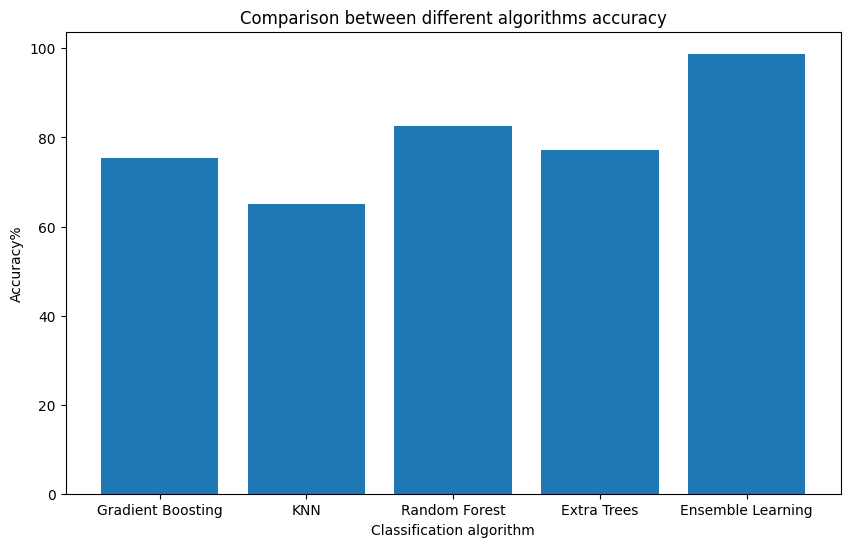

In [ ]:
import matplotlib.pyplot as plt

accuracy = ['Gradient Boosting','KNN','Random Forest','Extra Trees','Ensemble Learning']
values = [75.3,65.1,82.5,77.1,98.8]
plt.figure(figsize=(10,6))
plt.bar(accuracy, values)
# Displaying the bar plot
plt.xlabel('Classification algorithm')
plt.ylabel('Accuracy%')
plt.title('Comparison between different algorithms accuracy')
plt.show()

Varying testsizes

Test size: 0.1, Accuracy: 1.0000
Test size: 0.2, Accuracy: 0.9880
Test size: 0.3, Accuracy: 0.9880
Test size: 0.4, Accuracy: 0.9850
Test size: 0.5, Accuracy: 0.9880


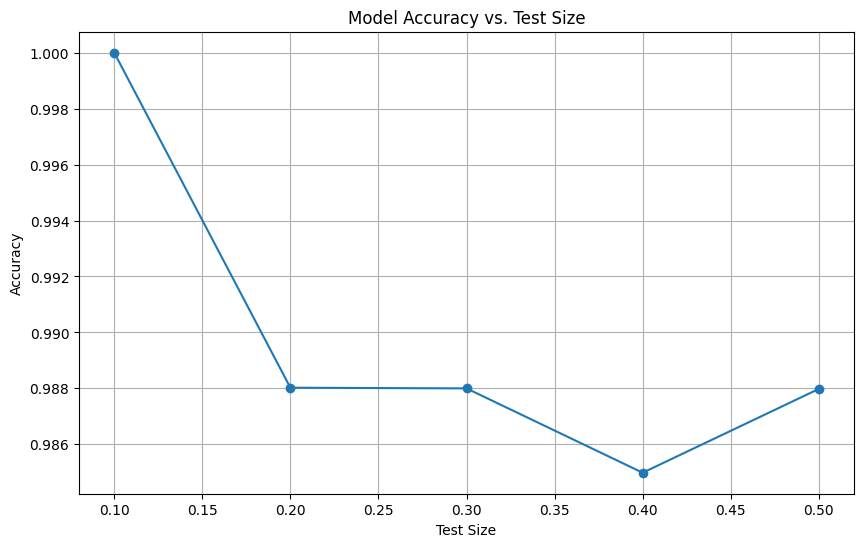

In [ ]:
# Assuming 'prod_model' is preloaded with data
X, y = prod_model.iloc[:, 1:73], prod_model['target']
cols = list(X.columns)

# Define different test sizes
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []

+
# Define estimators for VotingClassifier
estimators = [("KNN", KNN), ("rf", rf), ("Extra", Extra), ("GD", GD)]
ensemble = VotingClassifier(estimators, voting="hard")

for test_size in test_sizes:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)

    # Drop rows with NaN values from train and test dataframes
    X_train_dropped = X_train.dropna()
    y_train_dropped = y_train[X_train_dropped.index]
    X_test_dropped = X_test.dropna()
    y_test_dropped = y_test[X_test_dropped.index]

    # Converting column names to strings
    X_train_dropped.columns = X_train_dropped.columns.astype(str)
    X_test_dropped.columns = X_test_dropped.columns.astype(str)

    # Fit and score the ensemble model
    ensemble.fit(X_train_dropped, y_train_dropped)
    accuracy = ensemble.score(X_test_dropped, y_test_dropped)
    accuracies.append(accuracy)
    print(f"Test size: {test_size}, Accuracy: {accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, accuracies, marker='o')
plt.title('Model Accuracy vs. Test Size')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


Correlation coefficient

movie title                0
imdb rating              407
imdb raters              407
mpaa                    3974
genres                     8
director                  10
writer                    32
stars                    204
country                    0
language                   0
release date             728
budget                  5365
opening weekend         6571
gross usa               6477
cumulative worldwide    5904
production companies     720
runtime (min)            735
dtype: int64
                      imdb rating  imdb raters    budget  opening weekend  \
imdb rating              1.000000     0.587997  0.280039         0.274605   
imdb raters              0.587997     1.000000  0.467866         0.485493   
budget                   0.280039     0.467866  1.000000         0.772861   
opening weekend          0.274605     0.485493  0.772861         1.000000   
gross usa                0.386920     0.596113  0.762625         0.946347   
cumulative worldwide     0.36545

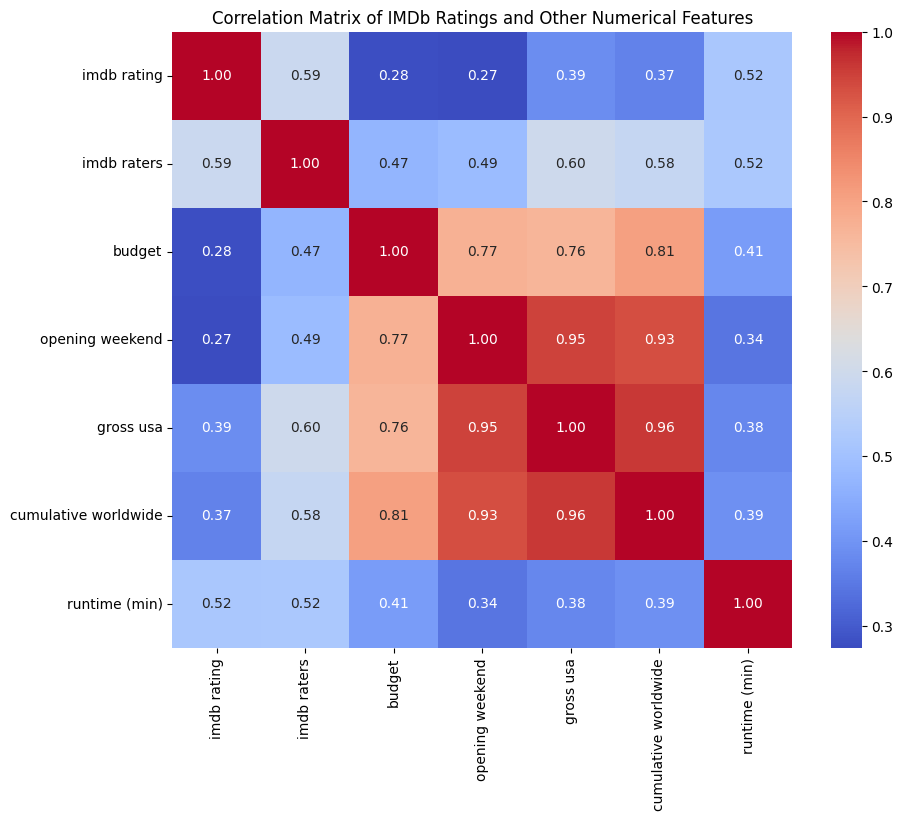

In [ ]:
data = pd.concat([movies_8000,df1,df2])
# Check for missing values
print(data.isnull().sum())

# For simplicity, drop rows with any missing values in the columns of interest
data.dropna(subset=['imdb rating', 'imdb raters', 'budget', 'opening weekend', 'gross usa', 'cumulative worldwide', 'runtime (min)'], inplace=True)

# Convert relevant fields to appropriate data types if necessary
data['budget'] = pd.to_numeric(data['budget'], errors='coerce')
data['opening weekend'] = pd.to_numeric(data['opening weekend'], errors='coerce')
data['gross usa'] = pd.to_numeric(data['gross usa'], errors='coerce')
data['cumulative worldwide'] = pd.to_numeric(data['cumulative worldwide'], errors='coerce')
data['runtime (min)'] = pd.to_numeric(data['runtime (min)'], errors='coerce')


# Compute the correlation matrix for selected features
correlation_matrix = data[['imdb rating', 'imdb raters', 'budget', 'opening weekend', 'gross usa', 'cumulative worldwide', 'runtime (min)']].corr()
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of IMDb Ratings and Other Numerical Features')
plt.show()


In [ ]:





# Individual metrics
precision = precision_score(y_test_dropped, y_pred, average='macro')  # You can change average to 'micro', 'macro', 'weighted' or None
recall = recall_score(y_test_dropped, y_pred, average='macro')
f1 = f1_score(y_test_dropped, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Using classification_report to get all metrics, including support per class
report = classification_report(y_test_dropped, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_dropped, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
# Assuming 'prod_model' is preloaded with data
X, y = prod_model.iloc[:, 1:73], prod_model['target']
cols = list(X.columns)

# Define different test sizes
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []

# Define estimators for VotingClassifier
estimators = [("KNN", KNN), ("rf", rf), ("Extra", Extra), ("GD", GD)]
ensemble = VotingClassifier(estimators, voting="hard")

for test_size in test_sizes:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)

    # Drop rows with NaN values from train and test dataframes
    X_train_dropped = X_train.dropna()
    y_train_dropped = y_train[X_train_dropped.index]
    X_test_dropped = X_test.dropna()
    y_test_dropped = y_test[X_test_dropped.index]

    # Converting column names to strings
    X_train_dropped.columns = X_train_dropped.columns.astype(str)
    X_test_dropped.columns = X_test_dropped.columns.astype(str)

    # Fit and score the ensemble model
    ensemble.fit(X_train_dropped, y_train_dropped)
    accuracy = ensemble.score(X_test_dropped, y_test_dropped)
    accuracies.append(accuracy)
    print(f"Test size: {test_size}, Accuracy: {accuracy:.4f}")



NameError: name 'prod_model' is not defined